In [185]:
'''
Baseball Pitcher Classification
Andrew Nee
'''
import numpy as np
import pandas as pd

df_init = pd.read_csv('fangraphs_season_level.csv')

df = df_init[['NameASCII', 'PlayerId', 'Throws', 'Season', 'Role', 'G', 'IP', 'TBF', 'K_pct', 'BB_pct', 'FIP', 'xFIP', 'SIERA', 'WAR', 
              'WPA', 'WPA_to_LI', 'SwStr_pct', 'Soft_pct', 'Med_pct', 'Hard_pct', 'GB_pct', 'LD_pct', 'FB_pct', 'SD', 'MD',
             'Stuff_plus', 'Location_plus', 'Pitching_plus']]

# Relief pitcher = 0, Starting Pitcher = 1
df.loc[(df['Role'] == 'RP', 'Role')] = 0
df.loc[(df['Role'] == 'SP', 'Role')] = 1




In [186]:
# weighted average of 2021, 2022, 2023 seasons    
# lets make the weight [1,2,3]
df_nums = df.drop(['NameASCII', 'Throws'], axis = 1)

df_nums.loc[(df['Season'] == 2021, 'Season')] = 1
df_nums.loc[(df['Season'] == 2022, 'Season')] = 2
df_nums.loc[(df['Season'] == 2023, 'Season')] = 3

# i'm dropping rows with NaN values as these pitchers had extremely minimal outings 
df_nums.dropna(subset=["Stuff_plus", "SIERA", 'Soft_pct'], inplace=True)

def avg_seasons(PlayerId):
    '''
    Takes the weighted average of a player's stats. Doesn't average stats related to amount played.
    
    
    '''
    w_avg_lst = []
    
    # dataframe of just one player
    player_df = df_nums[df_nums['PlayerId'] == PlayerId].copy()
    lst = player_df['Season'].tolist()
   
    # get stat column names
    stats_df = player_df.iloc[: , 6:]
    col_names = list(stats_df.columns.values)
    
    # iterate over columns to get weighted average and make new dataframe
    for column, vals in stats_df.items():
        
        vals_lst = vals.tolist()
        weighted_avg = np.average(vals_lst, weights = lst)
        
        w_avg_lst.append(weighted_avg)
     
    df = pd.DataFrame([w_avg_lst], columns = col_names)
    df.insert(0, "PlayerId", PlayerId, True)
    
    role = player_df.loc[(player_df['PlayerId'] == PlayerId) & (player_df['Season'] == lst[-1]), 'Role'].iloc[0]
    df.insert(1, "Role", role, True)


    return df
display(avg_seasons(27498))

,PlayerId,Role,K_pct,BB_pct,FIP,xFIP,SIERA,WAR,WPA,WPA_to_LI,...,Med_pct,Hard_pct,GB_pct,LD_pct,FB_pct,SD,MD,Stuff_plus,Location_plus,Pitching_plus
0,27498,1,0.330762,0.090963,3.160212,3.353195,3.362736,3.279872,1.26284,1.781971,...,0.50065,0.3384,0.343733,0.213746,0.442521,1.875,0.25,132.359723,101.764679,109.603258


In [187]:
# now lets get a list of all the playerIDs so we can make a master dataframe of all weighted data

p_id = df_nums['PlayerId'].unique()

lst_of_df = list()

for player in p_id:
    
    lst_of_df.append(avg_seasons(player))
    
master_df = pd.concat(lst_of_df, ignore_index=True)


In [188]:
# cross validation to find optimal k

def get_X_y(df):
    """
    Parameters: dataframe
    Returns: dataframe, array
    Does: returns demographic info as X and an array corresponding parties as y
    """
    y = df["Role"].values
    y=y.astype('int')
    
    X = df.drop(['Role', 'PlayerId'], axis = 1)
    
    return X,y

X,y = get_X_y(master_df)

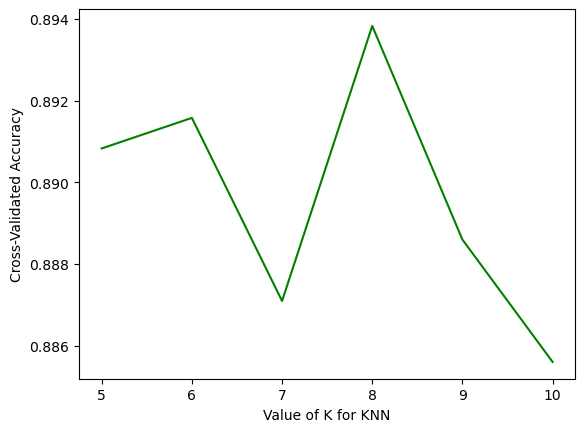

In [189]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

# choose k between 5 to 11
k_range = list(range(5, 11))
k_scores = []

# use iteration to caclulator different k in models, then return the average based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    k_folds = KFold(n_splits = 5, random_state = 0, shuffle = True)
    scores = cross_validate(knn, X, y, cv=k_folds, scoring='accuracy')
    k_scores.append(scores['test_score'].mean())
    
# plot
plt.plot(k_range, k_scores, color = 'green')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#plt.savefig('k_value.png', bbox_inches = 'tight')
plt.show()


In [190]:
print('Accuracy Max K value', k_scores.index(max(k_scores)) + 5)
print('Accuracy Max K score',max(k_scores))
print('Accuracy Min K value',k_scores.index(min(k_scores)) + 5)
print('Accuracy Min K score', min(k_scores))

Accuracy Max K value 8
Accuracy Max K score 0.8938314047738836
Accuracy Min K value 10
Accuracy Min K score 0.8856000894404381


In [191]:
from sklearn.model_selection import train_test_split

# optimal accuracy knn classifier
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [204]:
y_hats = knn.predict(X)

master_df.insert(2,'Preds', y_hats)

df_temp = df.drop(['Throws'], axis = 1)
df_temp.dropna(subset=["Stuff_plus", "SIERA", 'Soft_pct'], inplace=True)

df1 = df_temp[['PlayerId', 'NameASCII']].copy()
df2 = master_df.copy()

df3 = pd.merge(df1, df2, on='PlayerId', how='left')

display(df3)


ValueError: cannot insert Preds, already exists

In [205]:
#master_df.to_csv('master.csv', index=False)
df3.to_csv('masterv2.csv', index=False)
#df_temp.to_csv('help.csv', index=False)